**1) Loading the Dataset & Print Schema**

In [1]:
import pandas as pd
df = pd.read_csv("/content/Updated_Inpatient_Charges.csv")

print("Rows, Columns:", df.shape)

# Schema overview
df.info()

Rows, Columns: (163065, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 19 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   drg_definition                        163065 non-null  object
 1   provider_id                           163065 non-null  int64 
 2   provider_name                         163065 non-null  object
 3   provider_street_address               163065 non-null  object
 4   provider_city                         163065 non-null  object
 5   provider_state                        163065 non-null  object
 6   provider_zip_code                     163065 non-null  int64 
 7   hospital_referral_region_description  163065 non-null  object
 8   total_discharges                      163065 non-null  int64 
 9   average_covered_charges               163065 non-null  object
 10  average_total_payments                163065 non-nul

**2) Row Count Validation**

In [12]:
expected_rows = len(df)
print("Row count:", expected_rows)

Row count: 163065


**3) Column Name Standardization**

In [13]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("-", "_")
df.head(2)

,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,total_discharges,average_covered_charges,...,average_medicare_payments,age,gender,admission_type,length_of_stay,year,admission_date,discharge_date,length_of_stay_kpi,month
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,...,$4763.73,68,Female,Newborn,10,2016,2016-10-28,2016-11-04,7,10
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,...,$4976.71,39,Male,Emergency,15,2021,2021-11-06,2021-11-26,20,11


**4) Enforce Schema (Date Fields)**

In [3]:
# Convert admission_date to datetime
df['admission_date'] = pd.to_datetime(df['admission_date'], errors='coerce')

print(df['admission_date'].head())

0   2016-10-28
1   2021-11-06
2   2023-10-10
3   2017-06-17
4   2019-10-07
Name: admission_date, dtype: datetime64[ns]


**5) Missing Values Check**

In [14]:
missing_log = df.isnull().sum().reset_index()
missing_log.columns = ["column", "missing_count"]
missing_log

,column,missing_count
0,drg_definition,0
1,provider_id,0
2,provider_name,0
3,provider_street_address,0
4,provider_city,0
5,provider_state,0
6,provider_zip_code,0
7,hospital_referral_region_description,0
8,total_discharges,0
9,average_covered_charges,0


**6) Fill missing values**

In [15]:
# Since Exercise 5 showed there are NO missing values,
# no imputation is required.
print("No missing values found. Skipping imputation step.")

No missing values found. Skipping imputation step.


**7) Remove duplicates**

In [16]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]

print("Rows before:", before)
print("Rows after:", after)

Rows before: 163065
Rows after: 163065


**8) Count unique patients per diagnosis**

In [17]:
# Patient count by DRG Definition (Diagnosis Related Group)
patient_count_by_diagnosis = df.groupby('drg_definition')['provider_id'].count().reset_index()
patient_count_by_diagnosis.rename(columns={'provider_id': 'patient_count'}, inplace=True)

print(patient_count_by_diagnosis.head())

                                      drg_definition  patient_count
0           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC           1079
1  057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...           1201
2  064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...           1659
3  065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...           2269
4  066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...           1806


**9) Derive new KPI — length_of_stay**

In [4]:
# Ensure both columns are datetime
df['admission_date'] = pd.to_datetime(df['admission_date'], errors='coerce')
df['discharge_date'] = pd.to_datetime(df['discharge_date'], errors='coerce')

# Derive new KPI: length_of_stay
df['length_of_stay_kpi'] = (df['discharge_date'] - df['admission_date']).dt.days
print(df[['admission_date', 'discharge_date', 'length_of_stay_kpi']].head())

  admission_date discharge_date  length_of_stay_kpi
0     2016-10-28     2016-11-04                   7
1     2021-11-06     2021-11-26                  20
2     2023-10-10     2023-10-25                  15
3     2017-06-17     2017-06-28                  11
4     2019-10-07     2019-10-15                   8


**10) Partition-like summary — record counts by Year, Month**

In [5]:
# Extract year and month from admission_date
df['year'] = df['admission_date'].dt.year
df['month'] = df['admission_date'].dt.month

# Group partitioned data
partitioned = df.groupby(['year', 'month']).size().reset_index(name='record_count')
print(partitioned.head())

   year  month  record_count
0  2015      1          1546
1  2015      2          1385
2  2015      3          1562
3  2015      4          1495
4  2015      5          1499


**11) Top 5 categories (patients by hospital)**

In [18]:
top5_hospitals = (
    df.groupby('provider_name')['provider_id']
      .count()
      .reset_index(name='patient_count')
      .sort_values(by='patient_count', ascending=False)
      .head(5)
)

print(top5_hospitals)

                 provider_name  patient_count
924    GOOD SAMARITAN HOSPITAL            633
2644  ST JOSEPH MEDICAL CENTER            427
1660      MERCY MEDICAL CENTER            357
1645            MERCY HOSPITAL            347
2642        ST JOSEPH HOSPITAL            343


**12)  (patients per department per month)**

In [19]:
import calendar

pivot_table = pd.pivot_table(
    df,
    values='provider_id',
    index='drg_definition',
    columns=df['admission_date'].dt.month_name(),
    aggfunc='count',
    fill_value=0
)

pivot_table = pivot_table[[calendar.month_name[m] for m in range(1, 13)]]
pivot_table.head()

admission_date,January,February,March,April,May,June,July,August,September,October,November,December
drg_definition,,,,,,,,,,,,
039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,104,96,95,83,95,70,88,75,89,106,88,90
057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O MCC,92,89,121,101,98,91,87,104,115,109,89,105
064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W MCC,145,159,112,133,141,132,138,141,139,147,140,132
065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W CC,190,188,205,199,179,174,181,199,190,180,194,190
066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION W/O CC/MCC,147,146,165,162,136,136,149,141,145,156,158,165


**13) Correlation matrix (validate relationships)**

In [32]:
numeric_cols = ['age', 'average_covered_charges', 'average_total_payments', 'average_medicare_payments', 'length_of_stay']
corr_matrix = df[numeric_cols].corr()

corr_matrix

,age,average_covered_charges,average_total_payments,average_medicare_payments,length_of_stay
age,1.000000,-0.000276,-0.001918,-0.001303,0.003676
average_covered_charges,-0.000276,1.000000,0.774112,0.768927,0.002869
average_total_payments,-0.001918,0.774112,1.000000,0.989362,0.002309
average_medicare_payments,-0.001303,0.768927,0.989362,1.000000,0.001882
length_of_stay,0.003676,0.002869,0.002309,0.001882,1.000000


**14) Cleaned dataset CSV + Parquet**

In [28]:
# Save cleaned dataset
df.to_csv("cleaned_hospital_data.csv", index=False)
df.to_parquet("cleaned_hospital_data.parquet", index=False)

print("Files exported: cleaned_hospital_data.csv, cleaned_hospital_data.parquet")

Files exported: cleaned_hospital_data.csv, cleaned_hospital_data.parquet


**15) Create reusable ETL function (load → clean → transform)**

In [42]:
def etl_pipeline(file_path):
    # Load
    data = pd.read_csv(file_path)

    # Clean column names
    data.columns = data.columns.str.strip().str.lower().str.replace(" ", "_")

    # Fix currency fields: remove $ and commas, convert to float
    for col in ['average_covered_charges', 'average_total_payments', 'average_medicare_payments']:
        if col in data.columns:
            # Convert to string, strip whitespace, remove $ and commas using lambda with replace
            data[col] = data[col].astype(str).str.strip().apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)


    # Convert admission_date
    if 'admission_date' in data.columns:
        data['admission_date'] = pd.to_datetime(data['admission_date'], errors='coerce')

    # Handle missing values
    fill_dict = {}
    if 'average_total_payments' in data.columns:
        fill_dict['average_total_payments'] = data['average_total_payments'].mean()
    if 'average_medicare_payments' in data.columns:
        fill_dict['average_medicare_payments'] = data['average_medicare_payments'].median()
    if 'gender' in data.columns:
        fill_dict['gender'] = data['gender'].mode()[0]

    data.fillna(fill_dict, inplace=True)

    # Remove duplicates
    data.drop_duplicates(inplace=True)

    # Transform → derive length_of_stay if discharge_date exists
    if 'discharge_date' in data.columns and 'admission_date' in data.columns:
        data['discharge_date'] = pd.to_datetime(data['discharge_date'], errors='coerce')
        data['length_of_stay'] = (data['discharge_date'] - data['admission_date']).dt.days

    return data

# Example usage
etl_df = etl_pipeline("/content/Updated_Inpatient_Charges.csv")
etl_df.head()

,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments,age,gender,admission_type,length_of_stay,year,admission_date,discharge_date
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,68,Female,Newborn,7,2016,2016-10-28,2016-11-04
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,39,Male,Emergency,20,2021,2021-11-06,2021-11-26
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,65,Male,Newborn,15,2023,2023-10-10,2023-10-25
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,35,Female,Newborn,11,2017,2017-06-17,2017-06-28
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,45,Female,Emergency,8,2019,2019-10-07,2019-10-15


**16) Histogram – patient age distribution**

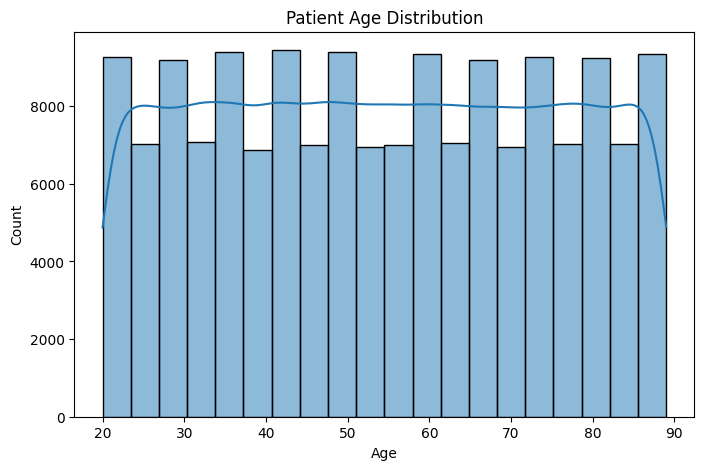

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['age'].dropna(), bins=20, kde=True)
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

**17) Boxplot – hospital charges by department**

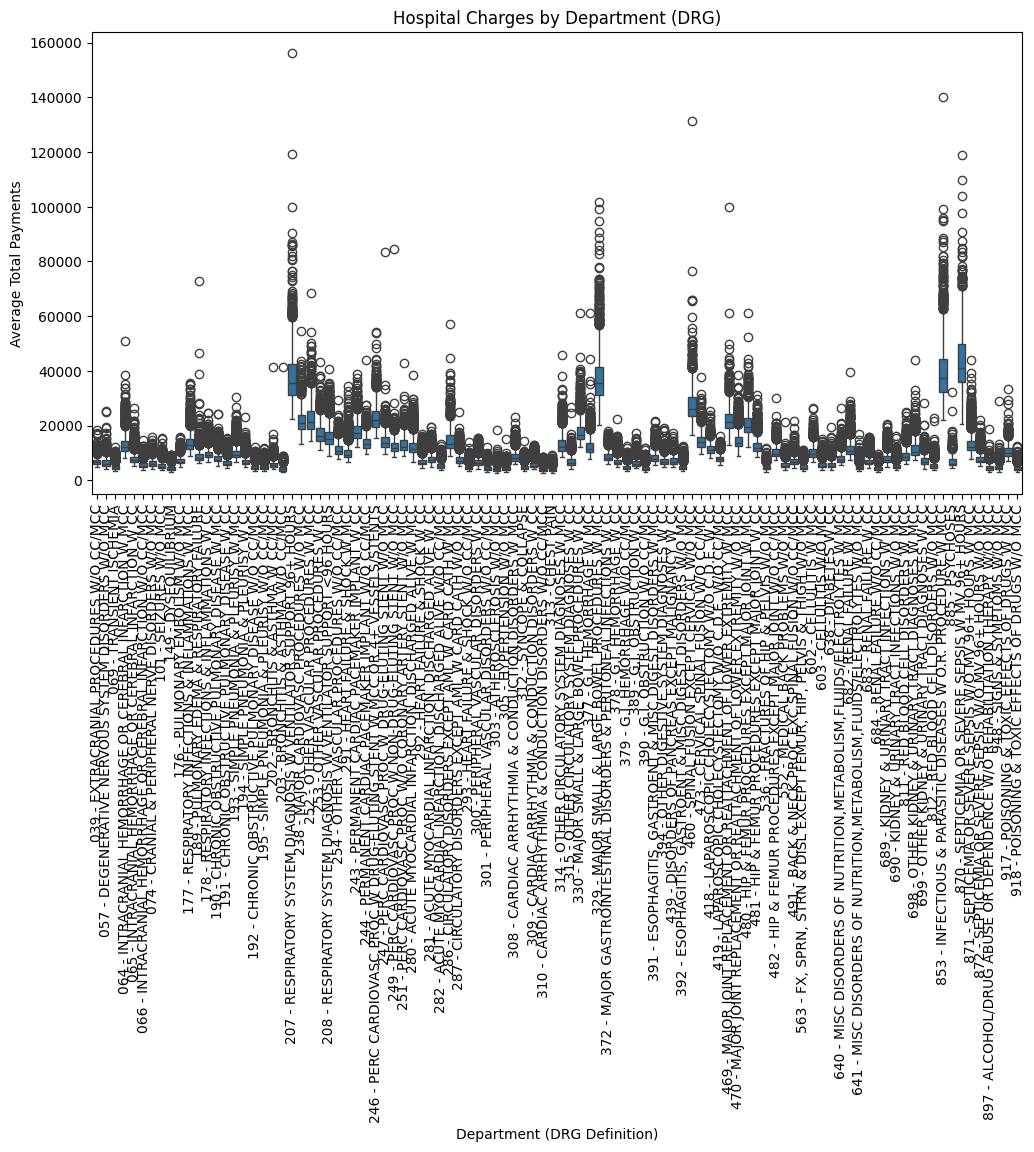

In [44]:
plt.figure(figsize=(12,6))
sns.boxplot(x='drg_definition', y='average_total_payments', data=df)
plt.xticks(rotation=90)
plt.title("Hospital Charges by Department (DRG)")
plt.xlabel("Department (DRG Definition)")
plt.ylabel("Average Total Payments")
plt.show()

**18) Pie chart – patient gender breakdown**

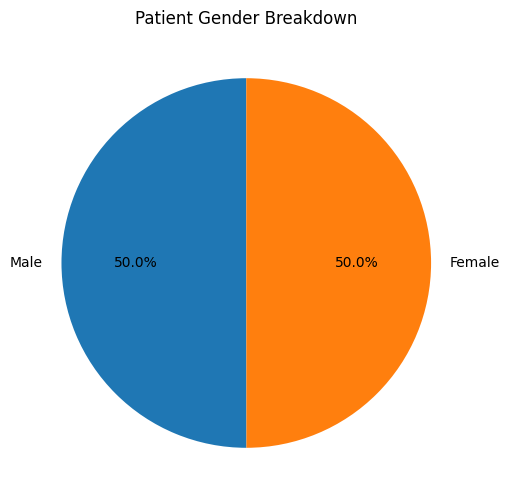

In [45]:
gender_counts = df['gender'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Patient Gender Breakdown")
plt.show()

**19) Line plot – monthly patient admissions**

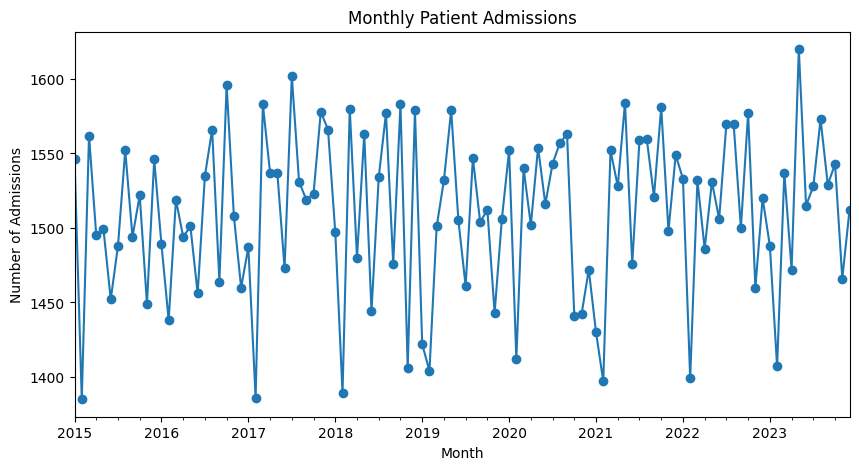

In [46]:
monthly_admissions = df.groupby(df['admission_date'].dt.to_period("M")).size()

plt.figure(figsize=(10,5))
monthly_admissions.plot(kind='line', marker='o')
plt.title("Monthly Patient Admissions")
plt.xlabel("Month")
plt.ylabel("Number of Admissions")
plt.show()

**20) Heatmap – correlation validation**

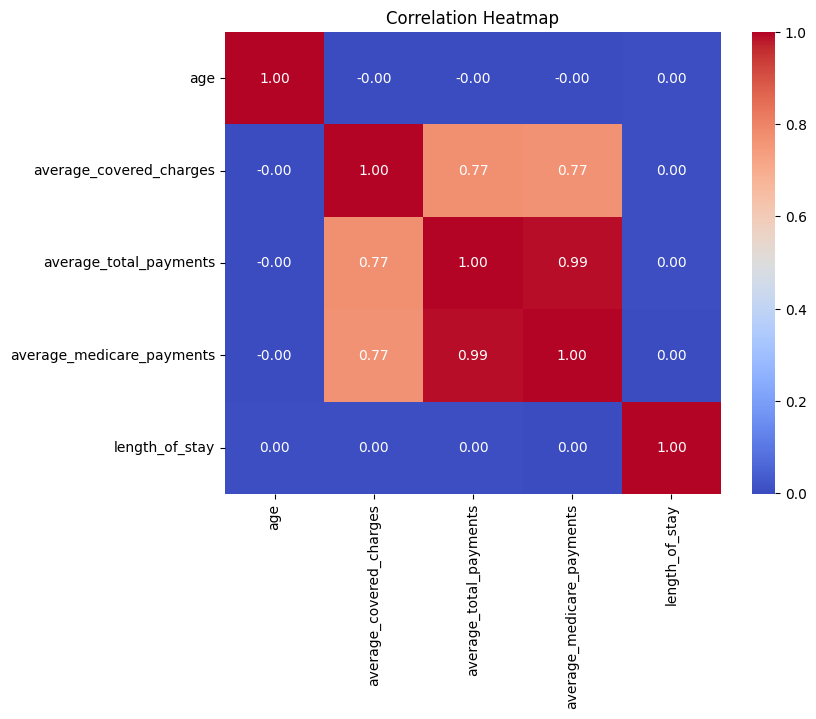

In [47]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()